# MsPASS Short Course
## Session 1:   Overview
The purpose of this notebook is to provide a overview of the main features of MsPASS that we will
be covering in this course.  The notebook will lead you through the following steps:

1.  We will assemble a small data set from the IRIS DMC using either web services.   That process
    is aimed to build a local copy of the data to drive later processing, which is currently the recommended way 
    of running MsPASS. 
2.  We will run a set of common preprocessing steps.  These are a mix of database operations to 
    associate the right source and receiver metadata with each waveform and some lightweight waveform 
    manipulation to window data around a theoretical P time and bundle the data into three-component
    data objects.  
3.  We illustrate how easy it is to translate a serial workflow to a parallel workflow.  The example we 
    will compute is a set of standard receiver functions computing with the multitaper method. 

This notebook assumes you already have docker running, launched the MsPASS container, 
and you are running this notebook by connecting to the notebook server running on the container.  
You won't be reading a local copy unless that is true.
## Preprocessing:  assembling a working data set for this session
### Source selection
We are going to be working with the reflection seismology equivalent of a shot gather.  
For this session we will be working with a single magnitude 7.0 aftershock of the 2012 
Tohoku earthquake recorded by the USArray.

The first step is to pull the detail source information and save it our database.

In [4]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
client=Client("IRIS")
t0=UTCDateTime('2011-04-07T14:32:44.100000Z')
starttime=t0-3600.0
endtime=t0+3600.0
lat0=38.3
lon0=142.5
minlat=lat0-3.0
maxlat=lat0+3.0
minlon=lon0-3.0
maxlon=lon0+3.0
minmag=6.5

cat=client.get_events(starttime=starttime,endtime=endtime,
        minlatitude=minlat,minlongitude=minlon,
        maxlatitude=maxlat,maxlongitude=maxlon,
        minmagnitude=minmag)
print(cat)

1 Event(s) in Catalog:
2011-04-07T14:32:44.100000Z | +38.251, +141.730 | 7.1 MW


Note the above is a pure obspy python script.   They define a *Catalog* object they use to store event information.  A *Catalog* is more or less an image of the quakeml format data delivered by FDSN web service calls that the IRIS DMC just responded to when you ran that box.  The next box makes the first use of a MsPASS.  This short script saves the *Catalog* we just created into the MsPASS database system (based on MongoDB):

In [1]:
from mspasspy.db.database import Database
from mspasspy.db.client import DBClient
dbclient=DBClient()
db=Database(dbclient,'shortcourse')

In [2]:
n=db.save_catalog(cat)
print('number of event entries saved in source collection=',n)

number of event entries saved in source collection= 1


#### Select stations and download station metadata
We now need to do parallel procedure to retrieve any relevant station information.  For this exercise we are going to use only data from the USArray "TA" stations, which have the SEED net code "TA".   As with sources we use obspy's web service client, but in this case we retrieve station data:

In [3]:
inv=client.get_stations(network='TA',starttime=starttime,endtime=endtime,
                        format='xml',channel='BH?',level='response')
net=inv.networks
x=net[0]
sta=x.stations
print("Number of stations retrieved=",len(sta))
print(inv)

Number of stations retrieved= 433
Inventory created at 2021-07-01T11:38:31.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.47
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2011-04-07...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			TA
		Stations (433):
			TA.034A (Hebronville, TX, USA)
			TA.035A (Encino, TX, USA)
			TA.035Z (Hargill, TX, USA)
			TA.109C (Camp Elliot, Miramar, CA, USA)
			TA.121A (Cookes Peak, Deming, NM, USA)
			TA.133A (Hamilton Ranch, Breckenridge, TX, USA)
			TA.134A (White-Moore Ranch, Lipan, TX, USA)
			TA.135A (Vickery Place, Crowley, TX, USA)
			TA.136A (Ennis, TX, USA)
			TA.137A (Heron Place, Grand Saline, TX, USA)
			TA.138A (Matatall Enterprise, Big Sandy, TX, USA)
			TA.139A (Bunkhouse Ranch, Marshall, TX, USA)
			TA.140A (Cam and Jess, Hughton, LA, USA)
			TA.141A (Papa Simpson, Farm, Arcadia, LA, USA)
			TA.142A (Monroe, LA, USA)
			TA.143A (Socs Landing, Pioneer, LA, USA)
			TA.144A (Alexan

Similar to the source data, obspy's web service client creates an image of the returned stationxml data that they call an *Inventory*.   We next use a parallel, simple database method to save this python object to our working database:

In [4]:
ret=db.save_inventory(inv)

Database.save_inventory processing summary:
Number of site records processed= 434
number of site records saved= 434
number of channel records processed= 1308
number of channel records saved= 1302


In this case, this function produced only a summary of what it wrote.  In later sessions we will help you understand more about this output.  There is a verbose mode we turned off that would have told us that the reason the last two lines have a different number is that web services returned 6 duplicates.   As those of you who have worked with a lot of IRIS data probably know there are a lot of station metadata inconsistencies in what you get from web services.   Anyone who has had to deal with experimental data totally understand why, but it is a truth and a never ending job people at DMC and other data centers face.   The point for this session is that save_inventory always checks for duplicates and will silently skip them unless the verbose option is turned on.  If running verbose the duplicates will still be skipped, but you will get an error message.  Although we skipped it here, in general we recommend running save_inventory in verbose mode to make sure you are aware of any warts in the station metadata. 

### Download waveform data
Next we retrieve the waveform data.   This will take a while even for this tiny data set, so in the class you will have to endure a lecture while that is in progress.  

In [5]:
from mspasspy.util.converter import Trace2TimeSeries
import os   # need this for directory handling
from obspy import UTCDateTime
# We need to recreate a db handle to deal using this incantation to get
# around a seed issue that is deep in the weeds.  We'll plan to discuss this later
db=Database(dbclient,'shortcourse',db_schema='mspass_lite.yaml', md_schema='mspass_lite.yaml')
dbsource=db.source
doc=dbsource.find_one()   
origin_time=doc['time']
# We need the ObjectId of the source to provide a cross reference to link our 
# waveform data to the right source.  Better to do this now than later as association 
# can be a big challenge
id=doc['_id']
        
print('Starting to download data for event with origin time=',UTCDateTime(origin_time))
start_offset=763.0-4*60.0   # 763 is an approximate P wave travel time to TA center
end_offset=1400.0+10*60.0
stime=origin_time+start_offset
etime=origin_time+end_offset
strm=client.get_waveforms(
            starttime=UTCDateTime(stime),
            endtime=UTCDateTime(etime),
            network='TA',
            station='*',
            channel='BH?',
            location='*'
        )
# The output of get_waveforms is an obspy Stream object. Stream objects are iterable 
# so we work through the group, converting each to a MsPASS TimeSeries, and then saving 
# the results to the database. 
i=0   # used as a counter for creating unique mseed file names in this script
filebase='shortcourse'
dir='./wf'
if not os.path.exists(dir):
    os.makedirs(dir)
for d in strm:
    # We use obspy's writer here to save these data as miniseed.  We will be using that version 
    # of the data set in a later session.  There writer by default uses the SAC model of one 
    # file per Trace so we have to create a large number of files.
    filename = "{base}_{count}.mseed".format(base=filebase,count=i)
    d.write(dir+"/"+filename,format='MSEED')
    i += 1
    d_mspass=Trace2TimeSeries(d)
    # Here is where we save the id linked to the source collection. 
    # We use a MsPASS convention that such metadata have name collection_id
    d_mspass['source_id'] = id
    #print('Saving data for sta=',d_mspass['sta'],' and chan=',d_mspass['chan'])
    db.save_data(d_mspass)   

Starting to download data for event with origin time= 2011-04-07T14:32:44.100000Z


There are a couple things worth noting about this script (in execution order, not importance):
1. We are again using obspy's web service client, but this time for waveform delivery.   The volume returned is orders of magnitude larger in this case than either of the above requests, which is why the response is slower.  The experience of this simple download will also show you why a workflow with a get_waveforms line to create the data set to start the workflow is not a good idea other than as a pure download step.   For any workflow the web service download step will be the bottleneck for the processing.  
2. We have to translate obpsy data objects to MsPASS data objects.  We will elaborate on why that is necessary in a later session, but for now realize that is the purpose of the call to the MsPASS function Trace2TimeSeries. 
3. We saved the data to a miniseed file for later use in this course.  That save uses the obspy Trace write method.
4. The last line is a key feature of MsPASS.  Note how simple it is to save a native MsPASS data object to the database;  a simple call to a method called *save_data*.   
### Data Preprocessing
#### Quick Look
Any form of data processing requires graphical displays at times to evaluate the results.  In MsPASS we currently have a basic plotter to handle native data types.  We will not cover plotting details in this course, but students are referred to the MsPASS tutorial on graphics for additional information and guidance on alternative approaches.

The following short script selects BHZ channels from the database and plots only the first 10 it finds.  

Number of BHZ channels= 429
Plotting only first 10


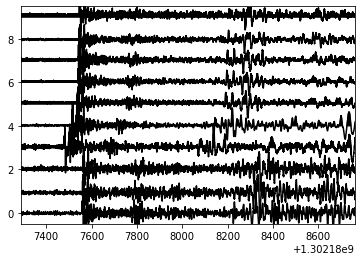

In [6]:
from mspasspy.ccore.seismic import TimeSeriesEnsemble
from mspasspy.graphics import SeismicPlotter
ensemble=TimeSeriesEnsemble()
query={ 'chan' : 'BHZ'}
n=db.wf_TimeSeries.count_documents(query)
print('Number of BHZ channels=',n)
print('Plotting only first 10')
curs=db.wf_TimeSeries.find(query).limit(10)
for doc in curs:
    # With the current mspass_lite schema these extra options are required
    d=db.read_data(doc)
    ensemble.member.append(d)
plotter=SeismicPlotter(normalize=True)
plotter.change_style('wtva')
plotter.plot(ensemble)

One thing to note about the plot above is that the time scale is unix epoch time, but the matplotlib routines we use for the plotting convert that axis to a readable scale in seconds relative to the start time.  

### Metadata Association
In a later section of this course we will go into more details about the database we use in MsPASS.  For the present the thing to recognize is that we previously downloaded source and receiver metadata and saved them to the database.   We also saved the waveform data in a separate step.   The waveform data were transferred as miniseed.  A property of miniseed is that a unique channel is defined by five key attributes:  network code, station code, channel code, (when set) a location code, and a time stamp.   The miniseed data have absolutely no reference to what source we are examining. Anyone who has dealt with miniseed data knows it is can be a thorny problem to associate the right source and receiver metadata with each channel of data.  We have a standard tool for associating channel metadata to TimeSeries objects illustrated by the following script:

In [7]:
cursor=db.wf_TimeSeries.find({})
for doc in cursor:
    net=doc['net']
    sta=doc['sta']
    chan=doc['chan']
    wftime=doc['starttime']
    chandoc=db.get_seed_channel(net,sta,chan,time=wftime)
    sitedoc=db.get_seed_site(net,sta,time=wftime)
    chanid=chandoc['_id']
    siteid=sitedoc['_id']
    wfid=doc['_id']
    match={'_id' : wfid}
    updatedef={'$set' : {'channel_id' : chanid, 'site_id' : siteid}}
    db.wf_TimeSeries.update_one(match,updatedef)        
               

There are likely some pieces of the above that might be properly labeled an "incantation", but the key thing to notice is the call the database methods _get_seed_channel_ and _get_seed_site_.  Both return a special MongoDB thing called an "ObjectID" that we use extensively in MsPASS for cross-referencing.   The reason is the ObjectIDs involved always have an index defined and yield fast searches at the cost of being defined by a not so human friendly id value.  The script above finds unique records where station metadata are stored and sets an id field in each waveform.   The is done here through the low-level _update_one_ method for the database handle.   

To show that did something useful here we read back the first 6 waveforms and show how source and receiver data are stored in the generalized headers for these data:

In [13]:
db=Database(dbclient,'shortcourse')
cursor=db.wf_TimeSeries.find({}).limit(6)
print('net sta chan channel_lat channel_lon channel_elev source_lat source_lon source_depth source_time')
normalize_list=['source','channel']
for doc in cursor:
    d=db.read_data(doc,normalize=normalize_list)
    print(d['net'],d['sta'],d['chan'],d['channel_lat'],d['channel_lon'],d['channel_elev'],
         d['source_lat'],d['source_lon'],d['source_depth'],UTCDateTime(d['source_time']))

net sta chan channel_lat channel_lon channel_elev source_lat source_lon source_depth source_time
TA 034A BHE 27.064699 -98.683296 0.155 38.2513 141.7296 53.2 2011-04-07T14:32:44.100000Z
TA 034A BHN 27.064699 -98.683296 0.155 38.2513 141.7296 53.2 2011-04-07T14:32:44.100000Z
TA 034A BHZ 27.064699 -98.683296 0.155 38.2513 141.7296 53.2 2011-04-07T14:32:44.100000Z
TA 035A BHE 26.937901 -98.102303 0.029 38.2513 141.7296 53.2 2011-04-07T14:32:44.100000Z
TA 035A BHN 26.937901 -98.102303 0.029 38.2513 141.7296 53.2 2011-04-07T14:32:44.100000Z
TA 035A BHZ 26.937901 -98.102303 0.029 38.2513 141.7296 53.2 2011-04-07T14:32:44.100000Z


## Simple Serial Workflows
In section we illustrate some simple MsPASS workflows that use simple serlia processing driven by for loops.  In the main section following we will show a parallel version of the most elaborate serial workflow.
### Cut around P time
Our first example just reads the first 5 waveforms in the database, applies a simple filter, computes a theoretical P wave arrival time from the source and receiver metadata, windows the data relative to that P wave arrival time, and then plots the data.  

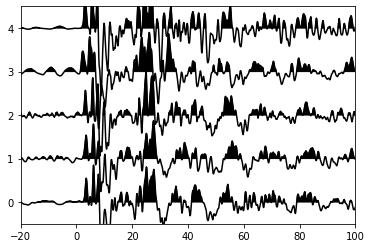

In [10]:
from mspasspy.algorithms.window import WindowData
from mspasspy.algorithms.signals import filter
from mspasspy.ccore.algorithms.basic import TimeWindow
from obspy.taup import TauPyModel
model = TauPyModel(model="iasp91")
from obspy.geodetics import gps2dist_azimuth,kilometers2degrees
# First we load all the data we currently have into a single ensemble object
ensemble=TimeSeriesEnsemble()
cursor=db.wf_TimeSeries.find({'chan' : 'BHZ'}).limit(5)
for doc in cursor:
    d=db.read_data(doc,normalize=normalize_list)
    ensemble.member.append(d)

# This a time window in time relative to P arrival around 
# which we cut each waveform
cutwin=TimeWindow(-20.0,100.0)
i=0
for d in ensemble.member:
    filter(d,'bandpass',freqmax=2.0,freqmin=0.005)
    stalat=d['channel_lat']
    stalon=d['channel_lon']
    srclat=d['source_lat']
    srclon=d['source_lon']
    depth=d['source_depth']
    otime=d['source_time']
    georesult=gps2dist_azimuth(srclat,srclon,stalat,stalon)
    # obspy's function we just called returns distance in m in element 0 of a tuple
    # their travel time calculator it is degrees so we need this conversion
    dist=kilometers2degrees(georesult[0]/1000.0)
    arrivals=model.get_travel_times(source_depth_in_km=depth,distance_in_degree=dist,phase_list=['P'])
    # Arrivals are returned in time order 0 is always the first arrival
    # This computes arrival time as an epoch time and shifts the data to put 0 at that time
    d.ator(otime+arrivals[0].time)
    #d=WindowData(d,cutwin)
    ensemble.member[i]=WindowData(d,cutwin)
    i+=1
plotter.plot(ensemble)

### Bundle into Seismogram objects

In [14]:
from mspasspy.algorithms.bundle import bundle_seed_data
ensemble=TimeSeriesEnsemble()
cursor=db.wf_TimeSeries.find({})
for doc in cursor:
    d=db.read_data(doc,normalize=normalize_list)
    ensemble.member.append(d)
d3c=bundle_seed_data(ensemble)
db.save_ensemble_data(d3c,data_tag='rawdata')

_fdsnws_dataselect_url http://service.iris.edu/fdsnws/dataselect/1/query
_format MSEED
_id 60df00514b8ba0746cf14142
calib 1.0
chan E
channel_edepth 0.0
channel_elev 0.062
channel_endtime 1340387999.0
channel_id 60dda9424b8ba0746cf12d24
channel_lat 33.257702
channel_lon -92.803001
channel_starttime 1299715200.0
delta 0.025
endtime 1302188764.100001
gridfs_id 60ddab1b4b8ba0746cf1413e
loc 
mseed AttribDict({'dataquality': 'M', 'number_of_records': 17, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 100441600})
net TA
npts 59081
processing ['ObsPy 1.2.2: trim(endtime=UTCDateTime(2011, 4, 7, 15, 6, 4, 100000)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2011, 4, 7, 14, 41, 27, 100000))', "ObsPy 1.2.2: filter(options={'freqmax': 2.0, 'freqmin': 0.01}::type='bandpass')", "ObsPy 1.2.2: filter(options={'freqmax': 2.0, 'freqmin': 0.01}::type='bandpass')", "ObsPy 1.2.2: filter(options={'freqmax': 2.0, 'freqmin': 0.01}::type='bandpass')"]
sampl

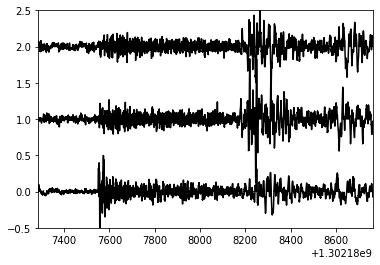

In [15]:
d0=d3c.member[0]
filter(d0,'bandpass',freqmax=2.0,freqmin=0.01)
printdoc(d0)
plotter.plot(d0)

Converting data downloaded miniseed into these three component data objects creates a bunch of metadata inconsistencies.   To see that let's just take a look at the metadata associated with the first 
seismogram.

In [65]:
n3c=db.wf_Seismogram.count_documents({})
print('Database current has ',n3c,' Seismogram objects')
doc=db.wf_Seismogram.find_one()
printdoc(doc)

Database current has  429  Seismogram objects
_id 60dccbeeeef8d7cf53ba4aab
_fdsnws_dataselect_url http://service.iris.edu/fdsnws/dataselect/1/query
_format MSEED
calib 1.0
chan BHZ
channel_edepth 0.0
channel_elev 0.062
channel_endtime 1340387999.0
channel_id 60dcc52aeef8d7cf53ba368d
channel_lat 33.257702
channel_lon -92.803001
channel_starttime 1299715200.0
delta 0.025
endtime 1302188764.100001
gridfs_id 60dccbeeeef8d7cf53ba4aac
mseed {'dataquality': 'M', 'number_of_records': 17, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 100441600}
READONLYERROR_net TA
npts 59081
processing ['ObsPy 1.2.2: trim(endtime=UTCDateTime(2011, 4, 7, 15, 6, 4, 100000)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2011, 4, 7, 14, 41, 27, 100000))']
sampling_rate 40.0
site_id 60dcc52aeef8d7cf53ba368b
READONLYERROR_source_depth 53.2
source_id 60dcc513eef8d7cf53ba3177
READONLYERROR_source_lat 38.2513
READONLYERROR_source_lon 141.7296
READONLYERROR_source_ma

Some example debris are:  (1) the "_format" field set to "MSEED", which is no longer valid; (2) multiple fields 
flagged with the "READONLYERROR" tag; and (3) "channel_id" which no longer makes sense because a channel 
loses meaning with a Seismogram.  

We can fix these easily with a special method in the Database object we call clean_collection

In [66]:
db.clean_collection('wf_Seismogram',delete_undefined=True)
doc=db.wf_Seismogram.find_one()
printdoc(doc)

_id 60dccbeeeef8d7cf53ba4aab
calib 1.0
delta 0.025
gridfs_id 60dccbeeeef8d7cf53ba4aac
npts 59081
sampling_rate 40.0
site_id 60dcc52aeef8d7cf53ba368b
source_id 60dcc513eef8d7cf53ba3177
starttime 1302187287.100001
storage_mode gridfs
time_standard UTC
utc_convertible True
history_object_id 59e8a7ad-a3b7-4ac4-8a45-86398b5be33c
elog_id 60dccbeeeef8d7cf53ba4aaa


In [16]:
from mspasspy.ccore.seismic import SeismogramEnsemble
ens3c=SeismogramEnsemble()
cursor=db.wf_Seismogram.find({}).limit(10)
normlist=['source','site']
for doc in cursor:
    d=db.read_data(doc,collection='wf_Seismogram',normalize=normlist)
    ens3c.member.append(d)
plotter.plot(ens3c)

MsPASSError: Error trying to extract Metadata with key=tmatrix
No value associated with this key is set in Metadata object
Expected an entry of type=boost::any


## RF Estimation workflow:  Serial version
Above we assembled data into Seismogram objects and saved them to the database.  In this example workflow we will generate a set of receiver function estimates driven by Seismogram inputs.  The serial job is a data driven loop over all Seismogram objects stored in the database.  For each seismogram we will do the following calculations:
1.  Detrend the data (for a Seismogram that means channel by channel)
2.  Lightly taper the ends to reduce filter startup transients.
3.  Bandpass filter the data.
4.  Window the data around the P wave arrival time.
5.  Run the deconvolution algorithm.
6.  Save the results.

In [6]:
from obspy.geodetics import degrees2kilometers
import math
from mspasspy.ccore.seismic import SlownessVector
def arrival_slowness_vector(obspy_arrival,azimuth=0.0):
    """
    Given an obspy arrival array member return the mspass SlownessVector.
    
    Obspy's taup calculator returns travel time data as a list with one class member for 
    each seismic phase. Inside that thing is a ray parameter, which is slowness in sec/degree.  
    A slowness vector has direction so we need to compute the direction from the azimuth.
    
    :param obspy_arrival: list member for which the slowness vector is to be computed.
    :param azimuth:  azimuth in degrees of propagation direction at receiver. 
    
    :return: SlownessVector form model estimate for this phase.
    
    """
    # theta is the standard angle in math definition of polar coordinate angle (degrees)
    theta=90.0-azimuth
    rtheta=math.radians(theta)   # radians needed for math calculations
    p=a.ray_param_sec_degree
    u=p/degrees2kilometers(1.0)
    ux=u*math.cos(rtheta)
    uy=u*math.sin(rtheta)
    return SlownessVector(ux,uy,0.0)

In [1]:
# temporary box for debugging
from mspasspy.db.database import Database
from mspasspy.db.client import DBClient
dbclient=DBClient()
db=Database(dbclient,'shortcourse')

In [19]:
import time
from mspasspy.algorithms.RFdeconProcessor import RFdeconProcessor
from mspasspy.algorithms.RFdeconProcessor import RFdecon
from mspasspy.ccore.utility import AntelopePf
# These are repeated from above, but useful to make this box standalone so one can more 
# easily just cut and paste to use it in another workflow
from mspasspy.algorithms.window import WindowData
from mspasspy.algorithms.signals import (filter, detrend)
from mspasspy.ccore.algorithms.basic import TimeWindow,CosineTaper
from mspasspy.ccore.utility import ErrorSeverity
from obspy.taup import TauPyModel
model = TauPyModel(model="iasp91")
from obspy.geodetics import gps2dist_azimuth,kilometers2degrees
normlist=['source','site']

# MsPASS allows parameters to be placed in a Antelope Pf format file.  We use 
# that here as an example of how to put parameters for a workflow in one place
pfhandle=AntelopePf('session1.pf')
# When using a pf to define constants always do that up front in case there are
# errors in the file
dtaperlength=pfhandle.get_double("data_taper_length")
fmax=pfhandle.get_double("filter_high_corner")
fmin=pfhandle.get_double("filter_low_corner")
awin_start=pfhandle.get_double("analysis_window_starttime")
awin_end=pfhandle.get_double("analysis_window_endtime")
vp0=pfhandle.get_double('vp0')
vs0=pfhandle.get_double('vs0')

# There is a fair amount of overhead to create the slepian tapers used in 
# the multitaper method.   We create an instance that defines the operator
# once and use it in the loop below
decon_operator=RFdeconProcessor(alg="MultiTaperXcor")


cursor=db.wf_Seismogram.find(query)
t0=time.time()
nlive=0
for doc in cursor:
    d=db.read_data(doc,collection='wf_Seismogram',normalize=normlist)
    print('working on data for station=',d['READONLYERROR_sta'])
    # detrend
    detrend(d)
    # bandpass filter
    filter(d,'bandpass',freqmax=fmax,freqmin=fmin)
    # cosine taper ends
    dtaper=CosineTaper(d.t0,d.t0+dtaperlength,d.endtime()-dtaperlength,d.endtime())
    dtaper.apply(d)
    # Time windowing - variant of above example 
    stalat=d['site_lat']
    stalon=d['site_lon']
    srclat=d['source_lat']
    srclon=d['source_lon']
    depth=d['source_depth']
    otime=d['source_time']
    georesult=gps2dist_azimuth(srclat,srclon,stalat,stalon)
    # obspy's function we just called returns distance in m in element 0 of a tuple
    # their travel time calculator it is degrees so we need this conversion
    dist=kilometers2degrees(georesult[0]/1000.0)
    baz=georesult[2]  # gps2dist_azimuth returns back azimuth as 2 of tuple.  We need azimuth
    azimuth=baz+180.0
    if azimuth>360.0:
        azimuth -= 360.0
    #print('DEBUG:  delta=',dist,' azimuth=',azimuth)
    if dist>95.0:
        d.kill()
        d.elog.log_error('session1_serial_script','No P wave - station is in the core shadow',ErrorSeverity.Invalid)
        print('Killed this datum - core shadow')
        db.save_data(d,data_tag='decon_output')
        continue
    arrivals=model.get_travel_times(source_depth_in_km=depth,distance_in_degree=dist,phase_list=['P'])
    # Arrivals are returned in time order 0 is always the first arrival
    # This computes arrival time as an epoch time and shifts the data to put 0 at that time
    a=arrivals[0]
    atime=a.time
    # Shift time 0 to the P wave arrival time
    d.ator(otime+atime)
    # Post the time used to Metadata
    d['P_iasp91']=atime   # Illustrates a made up key for Metadata
    decon_twin=TimeWindow(awin_start,awin_end)
    #print('DEBUG')
    #print(decon_twin.start,decon_twin.end)
    #print(d.t0,d.endtime())
    #print('sample interval=',d.dt,' and number of points=',d.npts)
    if decon_twin.start < d.t0:
        d.kill()
        d.elog.log_error('session_1_serial_script',
                         'Windowing failure - window start is before data starttime',ErrorSeverity.Invalid)
        print('killed this datum - windowing error')
        db.save_data(d,data_tag='decon_output')
    else:
        d=WindowData(d,decon_twin)
        # We transform the data to R,T,L using Kennett's free surface transformation matrix, which 
        # is implemented as a method in Seismogram
        u=arrival_slowness_vector(a,azimuth)
        d.free_surface_transformation(u,vp0,vs0)
        #  run deconvolution 
        decondata=RFdecon(decon_operator,d)
        # save result with a different data tag - automatically will go to wf_Seismogram
        db.save_data(decondata,data_tag='decon_output')
        nlive+=1
print('Total processing time=',time.time()-t0)
print('Number live data save=',nlive)
    

Starting RF estimation for  429  Seismogram objects
working on data for station= Z41A
working on data for station= Z40A
working on data for station= Z39A
working on data for station= Z38A
working on data for station= Z37A
working on data for station= Z36A
working on data for station= Z35A
working on data for station= Z34A
working on data for station= Z33A
working on data for station= Y40A
working on data for station= Y39A
working on data for station= Y38A
working on data for station= Y37A
working on data for station= Y36A
working on data for station= Y35A
working on data for station= Y34A
working on data for station= Y33A
working on data for station= Y22D
working on data for station= Y12C
killed this datum - windowing error
working on data for station= X40A
working on data for station= X39A
working on data for station= X38A
working on data for station= X37A
working on data for station= X36A
working on data for station= X35A
working on data for station= X34A
working on data for station=

working on data for station= I25A
killed this datum - windowing error
working on data for station= I05D
killed this datum - windowing error
working on data for station= I04A
killed this datum - windowing error
working on data for station= I03D
killed this datum - windowing error
working on data for station= I02D
killed this datum - windowing error
working on data for station= H37A
working on data for station= H36A
working on data for station= H35A
working on data for station= H34A
working on data for station= H33A
working on data for station= H32A
working on data for station= H31A
working on data for station= H29A
working on data for station= H28A
killed this datum - windowing error
working on data for station= H27A
killed this datum - windowing error
working on data for station= H26A
killed this datum - windowing error
working on data for station= H25A
killed this datum - windowing error
working on data for station= H17A
killed this datum - windowing error
working on data for station=

working on data for station= 439A
working on data for station= 438A
working on data for station= 437A
working on data for station= 436A
working on data for station= 435B
working on data for station= 434A
working on data for station= 433A
working on data for station= 348A
Killed this datum - core shadow
working on data for station= 347A
Killed this datum - core shadow
working on data for station= 346A
Killed this datum - core shadow
working on data for station= 345A
Killed this datum - core shadow
working on data for station= 344A
Killed this datum - core shadow
working on data for station= 343A
working on data for station= 342A
working on data for station= 341A
working on data for station= 340A
working on data for station= 339A
working on data for station= 338A
working on data for station= 337A
working on data for station= 336A
working on data for station= 335A
working on data for station= 334A
working on data for station= 333A
working on data for station= 246A
Killed this datum - core

## RF Estimation:  parallel job using Dask
MsPASS has support for two schedulers:  Dask and Spark.  In this exercise we are going to use Dask because it is slightly simpler to use.  In a later section we will talk about details of this job script, but for now a key point is to demonstrate that a job script to run a parallel job in MsPASS has only minor differences from the serial version.

We do have to make one point here to help you comprehend this job script;  a fundamental idea of both Spark and Dask is the idea of a map operator.  A map operator can be thought of as a function that takes a list of data objects (the dataset), does something to them, and creates a new list (dataset) of the modified data.  The schedulers handle the memory operations so the entire data set does not live in memory simultaneously. 

With that background, here is the above in parallel form (Note that for this notebook we could have dropped most of the initialization, but we retain it to emphasize the parallel structure):

In [ ]:
import time
from mspasspy.algorithms.RFdeconProcessor import RFdeconProcessor
from mspasspy.algorithms.RFdeconProcessor import RFdecon
from mspasspy.ccore.utility import AntelopePf
# These are repeated from above, but useful to make this box standalone so one can more 
# easily just cut and paste to use it in another workflow
from mspasspy.algorithms.window import WindowData
from mspasspy.algorithms.signals import (filter, detrend)
from mspasspy.ccore.algorithms.basic import TimeWindow,CosineTaper
from mspasspy.ccore.utility import ErrorSeverity
from obspy.taup import TauPyModel
model = TauPyModel(model="iasp91")
from obspy.geodetics import gps2dist_azimuth,kilometers2degrees
normlist=['source','site']

# We need this function to handle setting arrival times. The serial script should be 
# changed to use this same function.
def Ptime_shift(d,model):
    """
    Sets a predicted P wave arrival time using source and receiver coordinates and 
    model passed as arg 1 and time shifts data so time 0 is the predicted P wave arrival time.
    """
    stalat=d['site_lat']
    stalon=d['site_lon']
    srclat=d['source_lat']
    srclon=d['source_lon']
    depth=d['source_depth']
    otime=d['source_time']
    georesult=gps2dist_azimuth(srclat,srclon,stalat,stalon)
    # obspy's function we just called returns distance in m in element 0 of a tuple
    # With their travel time calculator it is degrees so we need this conversion
    dist=kilometers2degrees(georesult[0]/1000.0)
    baz=georesult[2]  # gps2dist_azimuth returns back azimuth as 2 of tuple.  We need azimuth
    azimuth=baz+180.0
    if azimuth>360.0:
        azimuth -= 360.0
    # the taup calculator fails if we ask for P in the core shadow.  This is a rough 
    # way to handle this for this example that works for the one event we are processing here
    # A more elegant method would worry about source depth
    if dist>95.0:
        d.kill()
        d.elog.log_error('session1_RF_script','No P wave - station is in the core shadow',
                         ErrorSeverity.Invalid)
    else:
        arrivals=model.get_travel_times(source_depth_in_km=depth,distance_in_degree=dist,phase_list=['P'])
        # Arrivals are returned in time order 0 is always the first arrival
        # This computes arrival time as an epoch time and shifts the data to put 0 at that time
        a=arrivals[0]
        atime=a.time
        # Post the time used to Metadata
        d['P_iasp91']=atime   # Illustrates a made up key for Metadata
        d.ator(otime+atime)
        # We also post the slowness data - computed by this function
        u=arrival_slowness_vector(a,azimuth)
        d['ux']=u.ux
        d['uy']=u.uy
    return d
def apply_free_surface_transformation(d,vp0,vs0):
    """
    Thin wrapper for free_surface_transformation method of Seismogram that assumes
    the components of a slowness vector for the transformation are in the Metadata 
    of d stored with the keys ux and uy
    """
    if d.dead():
        return d
    if 'ux' in d and 'uy' in d:
        ux=d['ux']
        uy=d['uy']
        u = SlownessVector(ux,uy)
        d.free_surface_transformation(u,vp0,vs0)
    else:
        d.elog.log_error('session1_RF_script','Slowness vector components were not set',
                         ErrorSeverity.Invalid)
        d.kill()
    return d
# These initializations are identical to the serial version

# MsPASS allows parameters to be placed in a Antelope Pf format file.  We use 
# that here as an example of how to put parameters for a workflow in one place
pfhandle=AntelopePf('session1.pf')
# When using a pf to define constants always do that up front in case there are
# errors in the file
dtaperlength=pfhandle.get_double("data_taper_length")
fmax=pfhandle.get_double("filter_high_corner")
fmin=pfhandle.get_double("filter_low_corner")
awin_start=pfhandle.get_double("analysis_window_starttime")
awin_end=pfhandle.get_double("analysis_window_endtime")
vp0=pfhandle.get_double('vp0')
vs0=pfhandle.get_double('vs0')

# There is a fair amount of overhead to create the slepian tapers used in 
# the multitaper method.   We create an instance that defines the operator
# once and use it in the loop below
decon_operator=RFdeconProcessor(alg="MultiTaperXcor")


cursor=db.wf_Seismogram.find(query)
t0=time.time()

# this script is identical to the serial script prior to this point.  
# Here is the first fundamental change:  our for loop is replaced by 
# this parallel reader that builds a Dask bag used to define the data set
dataset=db.read_distributed_data(cursor,collection='wf_Seismogram',normalize=normlist)
dataset=dataset.map(detrend)
dataset=dataset.map(filter,'bandpass',freqmax=fmax,freqmin=fmin)
dtaper=CosineTaper(d.t0,d.t0+dtaperlength,d.endtime()-dtaperlength,d.endtime())
dataset=dataset.map(dtaper.apply,inplace_return=True)
dataset=dataset.map(set_P_time,model)
dataset=dataset.map(WindowData,decon_twin)
dataset=dataset.map(apply_free_surface_transformation,vp0,vs0)
dataset=dataset.map(RFdecon,decon_operator)
dataset.map(save_data,collection='wf_Seismogram',data_tag='parallel_decon_output')
dataset.compute()